In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Preprocessing

In [2]:
df = pd.read_csv ('application_data.csv')
target = np.asarray(df['TARGET'])
df.drop('TARGET', axis=1, inplace=True)
df.drop('SK_ID_CURR', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=0, stratify = target)
X_train.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace = True)

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=2/9, random_state=0, stratify = y_train)
X_train.reset_index(drop=True, inplace = True)
X_validation.reset_index(drop=True, inplace = True)

In [4]:
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
drop_columns = X_train.columns[percent_missing >= 40]

In [5]:
X_train.drop(labels=drop_columns, axis=1, inplace= True)
X_validation.drop(labels=drop_columns, axis=1, inplace= True)
X_test.drop(labels=drop_columns, axis=1, inplace= True)

In [7]:
def fill_blanks (df):
    dict_fills = {}
    for each_column in df.columns:
        if each_column in df.select_dtypes(['object']).columns:
            dict_fills[each_column] = df[each_column].mode()[0]
        elif each_column in df.select_dtypes(['float64']).columns:
            dict_fills[each_column] = df[each_column].median()
        else:
            dict_fills[each_column] = df[each_column].median()
    return(dict_fills)

In [8]:
dict_fills = fill_blanks(X_train)

In [9]:
dict_fills

{'NAME_CONTRACT_TYPE': 'Cash loans',
 'CODE_GENDER': 'F',
 'FLAG_OWN_CAR': 'N',
 'FLAG_OWN_REALTY': 'Y',
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 148500.0,
 'AMT_CREDIT': 514777.5,
 'AMT_ANNUITY': 24907.5,
 'AMT_GOODS_PRICE': 450000.0,
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'NAME_INCOME_TYPE': 'Working',
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'REGION_POPULATION_RELATIVE': 0.01885,
 'DAYS_BIRTH': -15750.0,
 'DAYS_EMPLOYED': -1214.0,
 'DAYS_REGISTRATION': -4498.0,
 'DAYS_ID_PUBLISH': -3254.0,
 'FLAG_MOBIL': 1.0,
 'FLAG_EMP_PHONE': 1.0,
 'FLAG_WORK_PHONE': 0.0,
 'FLAG_CONT_MOBILE': 1.0,
 'FLAG_PHONE': 0.0,
 'FLAG_EMAIL': 0.0,
 'OCCUPATION_TYPE': 'Laborers',
 'CNT_FAM_MEMBERS': 2.0,
 'REGION_RATING_CLIENT': 2.0,
 'REGION_RATING_CLIENT_W_CITY': 2.0,
 'WEEKDAY_APPR_PROCESS_START': 'TUESDAY',
 'HOUR_APPR_PROCESS_START': 12.0,
 'REG_REGION_NOT_LIVE_REGION': 0.0,
 'REG_REGION_NOT_WORK_REGION': 0.0,


In [10]:
for each_column in X_train.columns:
    X_train[each_column].fillna(dict_fills[each_column], inplace = True)
    X_validation[each_column].fillna(dict_fills[each_column], inplace = True)
    X_test[each_column].fillna(dict_fills[each_column], inplace = True)

In [12]:
def ohencoder (df):
    # creating instance of one-hot-encoder
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    onehotencoder_data = enc.fit_transform(df[df.select_dtypes(['object']).columns]).toarray()
    list_columns_name = []
    for i in range(len(onehotencoder_data[0])):
        list_columns_name.append('Type '+ str(i+1))
    enc_df = pd.DataFrame(data=onehotencoder_data , columns= list_columns_name)
    # merge with main df bridge_df on key values
    df = df.join(enc_df)
    for col in df.select_dtypes(['object']).columns:
        df.drop(col, axis=1, inplace=True)

    return (df, enc)

In [13]:
def test_ohencoder (X_test, enc):
    onehotencoder_data = enc.transform(X_test[X_test.select_dtypes(['object']).columns]).toarray()
    list_columns_name = []
    for i in range(len(onehotencoder_data[0])):
        list_columns_name.append('Type '+ str(i+1))
    enc_test = pd.DataFrame(data=onehotencoder_data , columns= list_columns_name)

    X_test = X_test.join(enc_test)
    for col in X_test.select_dtypes(['object']).columns:
        X_test.drop(col, axis=1, inplace=True)

    return(X_test)

In [14]:
X_train, transfer_onehot = ohencoder(X_train)

In [15]:
X_validation = test_ohencoder (X_validation, transfer_onehot)
X_test = test_ohencoder (X_test, transfer_onehot)

In [16]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# y_train = y_resampled.copy()

In [17]:
learn_scaler=StandardScaler().fit(X_train)

standard_X_train = learn_scaler.transform(X_train)
standard_X_validation = learn_scaler.transform(X_validation)
standard_X_test = learn_scaler.transform(X_test)

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=15, random_state=0 )
clf.fit(standard_X_train, y_train)


RandomForestClassifier(max_depth=15, random_state=0)

In [19]:
FIorder = clf.feature_importances_
list_maxes = []
list_index = []
for i in range (50):
    list_maxes.append(FIorder[i])
    list_index.append(i)

for i in range (50 , len (FIorder)):
    for j in range(50):
        if (FIorder[i]>list_maxes[j]):
            list_maxes[j] = FIorder[i]
            list_index[j] = i
            break

list_good_cl = []
for i in list_index:
    list_good_cl.append(X_train.columns[i])


In [20]:
X_train_RF = X_train[list_good_cl].copy()
X_train_RF_std = standard_X_train[:,list_index].copy()
X_validation_RF_std = standard_X_validation[:,list_index].copy()
X_test_RF_std = standard_X_test[:,list_index].copy()

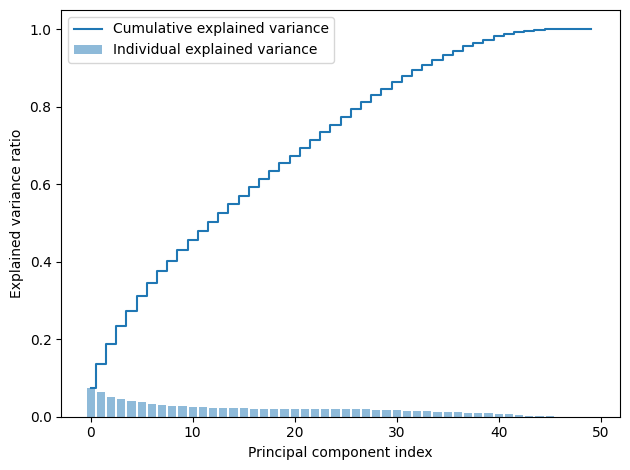

In [21]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_RF_std)
X_validation_pca = pca.transform(X_validation_RF_std)
X_test_pca = pca.transform(X_test_RF_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [22]:
reducted_X_train = np.copy(X_train_pca[:,:30])
reducted_X_validation = np.copy(X_validation_pca[:,:30])
reducted_X_test = np.copy(X_test_pca[:,:30])

In [23]:
reducted_X_train.shape

(215257, 30)

# MLP

In [24]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [25]:
model = Sequential()
model.add(Input(shape=(30,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
callback  = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5,
)

In [28]:
a , b = np.unique(y_train, return_counts= True)
count_lable = dict(zip(a,b))
ratio = {0: 1, 1: count_lable[0]/count_lable[1]}
ratio

{0: 1, 1: 11.38746619094205}

In [29]:
model.fit(reducted_X_train, y_train, validation_data=(reducted_X_validation, y_validation), 
    epochs=20, batch_size=128, class_weight= ratio, callbacks=[callback])

Epoch 1/20
1682/1682 [==============================] - 5s 2ms/step - loss: 1.1456 - accuracy: 0.6609 - val_loss: 0.6052 - val_accuracy: 0.6777
Epoch 2/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1288 - accuracy: 0.6622 - val_loss: 0.5877 - val_accuracy: 0.6885
Epoch 3/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1239 - accuracy: 0.6615 - val_loss: 0.6109 - val_accuracy: 0.6670
Epoch 4/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1197 - accuracy: 0.6665 - val_loss: 0.5968 - val_accuracy: 0.6769
Epoch 5/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1161 - accuracy: 0.6646 - val_loss: 0.5819 - val_accuracy: 0.6960
Epoch 6/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1125 - accuracy: 0.6693 - val_loss: 0.6291 - val_accuracy: 0.6511
Epoch 7/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1092 - accuracy: 0.6695 - val_loss: 0.6041 - val_accuracy:

In [30]:
y_hat_validation = model.predict(reducted_X_validation)
y_hat_validation

1922/1922 [==============================] - 2s 1ms/step


array([[0.5777109 ],
       [0.4762712 ],
       [0.33364865],
       ...,
       [0.7296059 ],
       [0.28789774],
       [0.6245447 ]], dtype=float32)

In [31]:
roc_auc_score(y_validation, y_hat_validation)

0.7192698038149887

In [32]:
def set_threshold (y_test, y_hat, cat_0=0, cat_1 = 0, total= 0, start=0.2, end=0.8, num=1000):
    thresholds = np.linspace(start, end, num , dtype= float)
    score_of_best_threshold = 0
    for threshold in thresholds :
        y_predict = [0 if val < threshold else 1 for val in y_hat]
        precision, recall, fscore, support = score(y_test, y_predict)
    
        score_of_threshold = (accuracy_score(y_test, y_predict)*total) + ((fscore[0])*cat_0) + ((fscore[1])*cat_1)

        if (score_of_threshold >= score_of_best_threshold):
            score_of_best_threshold = score_of_threshold
            best_threshold = threshold
    return(best_threshold)

In [33]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 4, total= 1, start=0.5, end=0.9, num=100)
threshold

0.7101010101010101

In [34]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]

print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56537
           1       0.23      0.32      0.27      4965

    accuracy                           0.86     61502
   macro avg       0.58      0.61      0.59     61502
weighted avg       0.88      0.86      0.87     61502



In [35]:
y_hat_test = model.predict(reducted_X_test)
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

961/961 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     28269
           1       0.22      0.32      0.26      2483

    accuracy                           0.86     30752
   macro avg       0.58      0.61      0.59     30752
weighted avg       0.88      0.86      0.87     30752



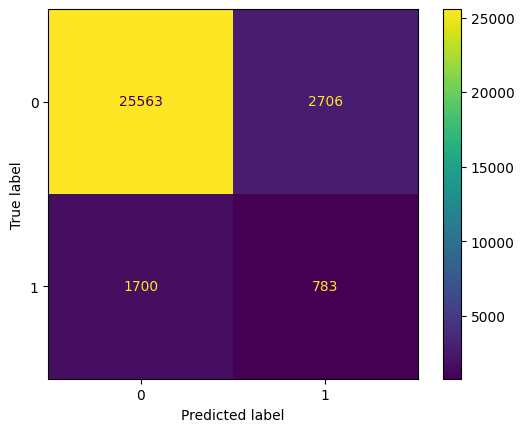

In [36]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# AutoEncoder
* Reconstruction Error
* Hidden State

In [37]:
normal_reducted_X_train = reducted_X_train[y_train == 0].copy()
abnormal_reducted_X_train = reducted_X_train[y_train == 1].copy()
normal_reducted_X_validation = reducted_X_validation[y_validation == 0].copy()
abnormal_reducted_X_validation = reducted_X_validation[y_validation == 1].copy()

In [38]:
normal_reducted_X_train.shape

(197880, 30)

In [39]:
from keras.models import Model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(64, activation="relu"),
      Dense(64, activation="relu"),
      Dense(32, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Dense(32, activation="relu"),
      Dense(64, activation="relu"),
      Dense(64, activation="relu"),
      Dense(30)])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [40]:
autoencoder.compile(optimizer='adam', loss='mae')

In [41]:
history = autoencoder.fit(normal_reducted_X_train, normal_reducted_X_train, 
          epochs=20, 
          batch_size=32,
          validation_data=(normal_reducted_X_validation, normal_reducted_X_validation),
          shuffle=True)

Epoch 1/20
6184/6184 [==============================] - 15s 2ms/step - loss: 0.4995 - val_loss: 0.4453
Epoch 2/20
6184/6184 [==============================] - 12s 2ms/step - loss: 0.4231 - val_loss: 0.4022
Epoch 3/20
6184/6184 [==============================] - 13s 2ms/step - loss: 0.3836 - val_loss: 0.3707
Epoch 4/20
6184/6184 [==============================] - 12s 2ms/step - loss: 0.3592 - val_loss: 0.3543
Epoch 5/20
6184/6184 [==============================] - 13s 2ms/step - loss: 0.3448 - val_loss: 0.3442
Epoch 6/20
6184/6184 [==============================] - 13s 2ms/step - loss: 0.3357 - val_loss: 0.3295
Epoch 7/20
6184/6184 [==============================] - 12s 2ms/step - loss: 0.3268 - val_loss: 0.3279
Epoch 8/20
6184/6184 [==============================] - 12s 2ms/step - loss: 0.3200 - val_loss: 0.3228
Epoch 9/20
6184/6184 [==============================] - 13s 2ms/step - loss: 0.3131 - val_loss: 0.3140
Epoch 10/20
6184/6184 [==============================] - 13s 2ms/step - l

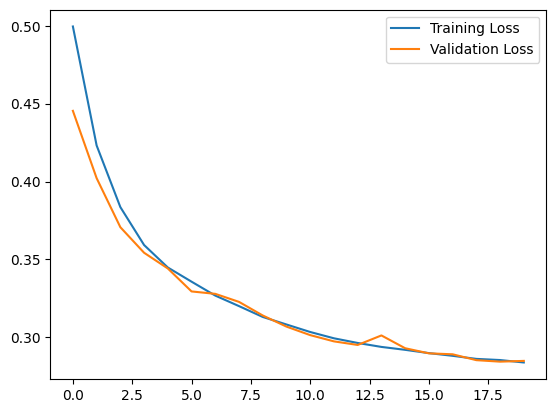

In [42]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


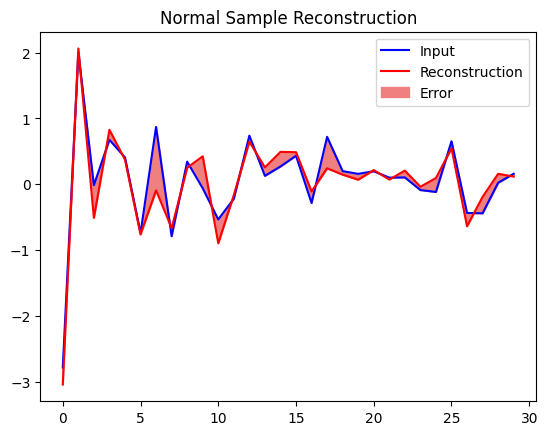

In [43]:
encoded_normal_data = autoencoder.encoder(normal_reducted_X_train).numpy()
decoded_normal_data = autoencoder.decoder(encoded_normal_data).numpy()

plt.plot(normal_reducted_X_train[2], 'b')
plt.plot(decoded_normal_data[2], 'r')
plt.fill_between(np.arange(30), decoded_normal_data[2], normal_reducted_X_train[2], color='lightcoral')
plt.title("Normal Sample Reconstruction")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

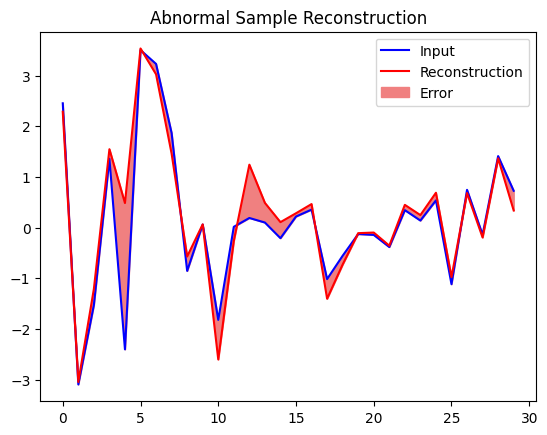

In [44]:
encoded_abnormal_data = autoencoder.encoder(abnormal_reducted_X_train).numpy()
decoded_abnormal_data = autoencoder.decoder(encoded_abnormal_data).numpy()

plt.plot(abnormal_reducted_X_train[2], 'b')
plt.plot(decoded_abnormal_data[2], 'r')
plt.fill_between(np.arange(30), decoded_abnormal_data[2], abnormal_reducted_X_train[2], color='lightcoral')
plt.title("Abnormal Sample Reconstruction")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

6184/6184 [==============================] - 7s 1ms/step


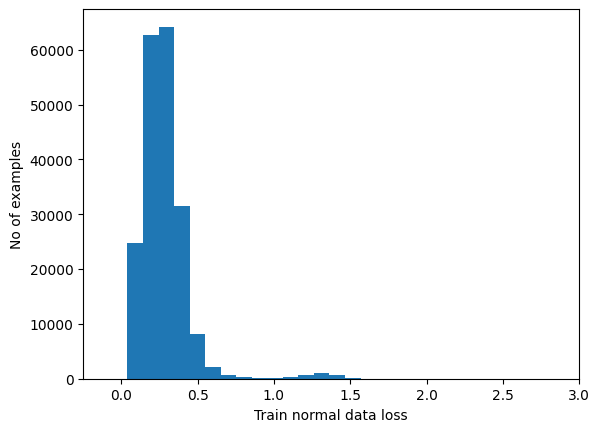

In [45]:
reconstructions = autoencoder.predict(normal_reducted_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_reducted_X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train normal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

544/544 [==============================] - 1s 1ms/step


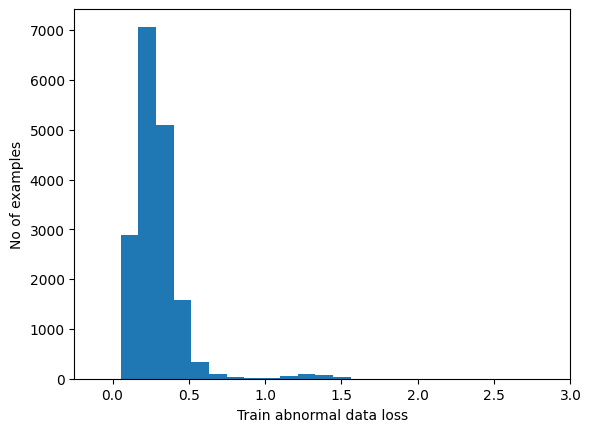

In [46]:
reconstructions = autoencoder.predict(abnormal_reducted_X_train)
train_loss = tf.keras.losses.mae(reconstructions, abnormal_reducted_X_train)

plt.hist(train_loss[None,:], bins=300)
plt.xlabel("Train abnormal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

1767/1767 [==============================] - 2s 1ms/step


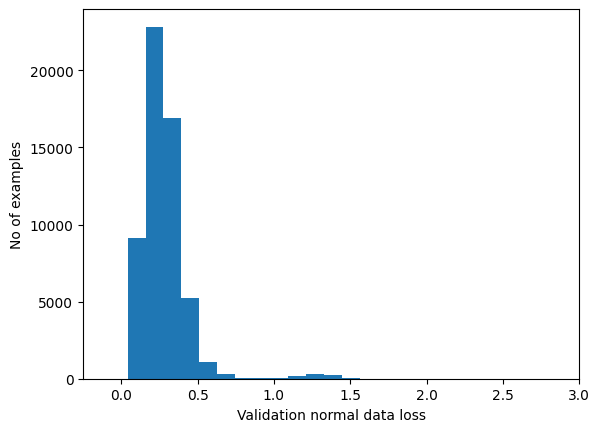

In [47]:
reconstructions = autoencoder.predict(normal_reducted_X_validation)
train_loss = tf.keras.losses.mae(reconstructions, normal_reducted_X_validation)

plt.hist(train_loss[None,:], bins=150)
plt.xlabel("Validation normal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

156/156 [==============================] - 0s 1ms/step


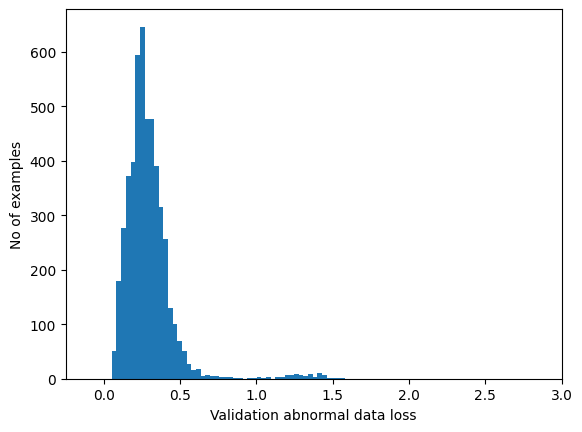

In [48]:
reconstructions = autoencoder.predict(abnormal_reducted_X_validation)
train_loss = tf.keras.losses.mae(reconstructions, abnormal_reducted_X_validation)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Validation abnormal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

### Reconstruction Error

In [49]:
validation_reconstructions = autoencoder.predict(reducted_X_validation)
y_hat_validation = tf.keras.losses.mae(validation_reconstructions, reducted_X_validation)
y_hat_validation = y_hat_validation.numpy().reshape(-1,1)

1922/1922 [==============================] - 2s 1ms/step


In [50]:
roc_auc_score(y_validation, y_hat_validation)

0.5215856806585376

In [51]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 4, total= 1, start=0.1, end=1.0, num=1000)
threshold

0.38648648648648654

In [52]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]

print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89     56537
           1       0.09      0.17      0.12      4965

    accuracy                           0.80     61502
   macro avg       0.51      0.51      0.50     61502
weighted avg       0.85      0.80      0.82     61502



In [53]:
test_reconstructions = autoencoder.predict(reducted_X_test)
y_hat_test = tf.keras.losses.mae(test_reconstructions, reducted_X_test)
y_hat_test = y_hat_test.numpy().reshape(-1,1)

961/961 [==============================] - 1s 1ms/step


In [54]:
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89     28269
           1       0.09      0.16      0.11      2483

    accuracy                           0.80     30752
   macro avg       0.50      0.51      0.50     30752
weighted avg       0.85      0.80      0.82     30752



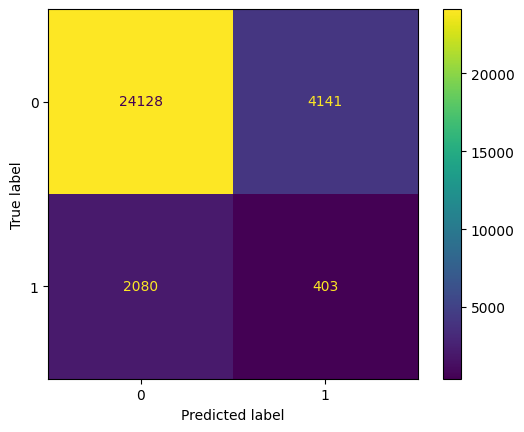

In [55]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

### Hidden State

In [56]:
train_hidden_state = autoencoder.encoder(reducted_X_train).numpy()
validation_hidden_state = autoencoder.encoder(reducted_X_validation).numpy()
test_hidden_state = autoencoder.encoder(reducted_X_test).numpy()

In [58]:
train_hidden_state.shape

(215257, 8)

In [62]:
mlp_for_hidden = Sequential()
mlp_for_hidden.add(Dense(64, activation='relu'))
mlp_for_hidden.add(Dense(64, activation='relu'))
mlp_for_hidden.add(Dense(1, activation='sigmoid'))

In [63]:
mlp_for_hidden.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
callback  = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5,
)

In [65]:
a , b = np.unique(y_train, return_counts= True)
count_lable = dict(zip(a,b))
ratio = {0: 1, 1: count_lable[0]/count_lable[1]}
ratio

{0: 1, 1: 11.38746619094205}

In [66]:
mlp_for_hidden.fit(train_hidden_state, y_train, validation_data=(validation_hidden_state, y_validation), 
    epochs=20, batch_size=128, class_weight= ratio, callbacks=[callback])

Epoch 1/20
1682/1682 [==============================] - 5s 2ms/step - loss: 1.2402 - accuracy: 0.5883 - val_loss: 0.6257 - val_accuracy: 0.6562
Epoch 2/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.2307 - accuracy: 0.5819 - val_loss: 0.6996 - val_accuracy: 0.5522
Epoch 3/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.2206 - accuracy: 0.5710 - val_loss: 0.6254 - val_accuracy: 0.6256
Epoch 4/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.2137 - accuracy: 0.5672 - val_loss: 0.5997 - val_accuracy: 0.6627
Epoch 5/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.2064 - accuracy: 0.5774 - val_loss: 0.6901 - val_accuracy: 0.5215
Epoch 6/20
1682/1682 [==============================] - 3s 2ms/step - loss: 1.1989 - accuracy: 0.5856 - val_loss: 0.6625 - val_accuracy: 0.5616
Epoch 7/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1909 - accuracy: 0.5989 - val_loss: 0.6621 - val_accuracy:

In [67]:
y_hat_validation = mlp_for_hidden.predict(validation_hidden_state)
y_hat_validation

1922/1922 [==============================] - 3s 1ms/step


array([[0.67021537],
       [0.31283146],
       [0.29067993],
       ...,
       [0.7047971 ],
       [0.2594008 ],
       [0.5840081 ]], dtype=float32)

In [68]:
roc_auc_score(y_validation, y_hat_validation)

0.690571378712487

In [69]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 4, total= 1, start=0.5, end=0.9, num=100)
threshold

0.6858585858585858

In [70]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]

print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56537
           1       0.20      0.32      0.24      4965

    accuracy                           0.84     61502
   macro avg       0.57      0.60      0.58     61502
weighted avg       0.88      0.84      0.86     61502



In [71]:
y_hat_test = mlp_for_hidden.predict(test_hidden_state)
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

961/961 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     28269
           1       0.19      0.32      0.24      2483

    accuracy                           0.84     30752
   macro avg       0.56      0.60      0.57     30752
weighted avg       0.88      0.84      0.85     30752



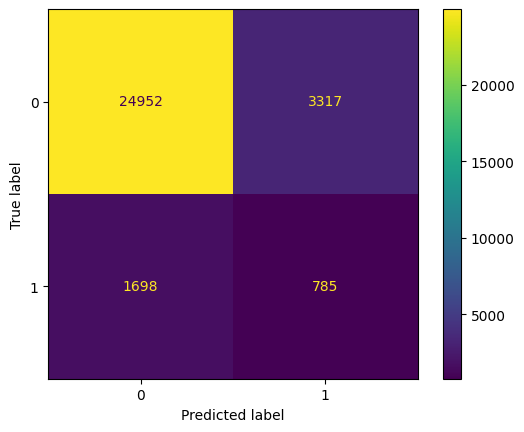

In [72]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Variational AutoEncoder
* Reconstruction Error
* Hidden State

In [78]:
class VAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(30)
        ]
    )

  @tf.function
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    return logits

  def call(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    predictions = self.decode(z)
    return(predictions)

In [79]:
vae = VAE(16)

In [80]:
vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [81]:
history = vae.fit(normal_reducted_X_train, normal_reducted_X_train, 
        epochs=10, 
        batch_size=32,
        validation_data=(normal_reducted_X_validation, normal_reducted_X_validation))

Epoch 1/10
6184/6184 [==============================] - 15s 2ms/step - loss: 0.1708 - accuracy: 0.7814 - val_loss: 0.0539 - val_accuracy: 0.8716
Epoch 2/10
6184/6184 [==============================] - 14s 2ms/step - loss: 0.0434 - accuracy: 0.8883 - val_loss: 0.0344 - val_accuracy: 0.9045
Epoch 3/10
6184/6184 [==============================] - 13s 2ms/step - loss: 0.0323 - accuracy: 0.9092 - val_loss: 0.0273 - val_accuracy: 0.9214
Epoch 4/10
6184/6184 [==============================] - 14s 2ms/step - loss: 0.0281 - accuracy: 0.9173 - val_loss: 0.0536 - val_accuracy: 0.8871
Epoch 5/10
6184/6184 [==============================] - 13s 2ms/step - loss: 0.0254 - accuracy: 0.9246 - val_loss: 0.0217 - val_accuracy: 0.9283
Epoch 6/10
6184/6184 [==============================] - 13s 2ms/step - loss: 0.0236 - accuracy: 0.9272 - val_loss: 0.0198 - val_accuracy: 0.9362
Epoch 7/10
6184/6184 [==============================] - 13s 2ms/step - loss: 0.0225 - accuracy: 0.9299 - val_loss: 0.0204 - val_ac

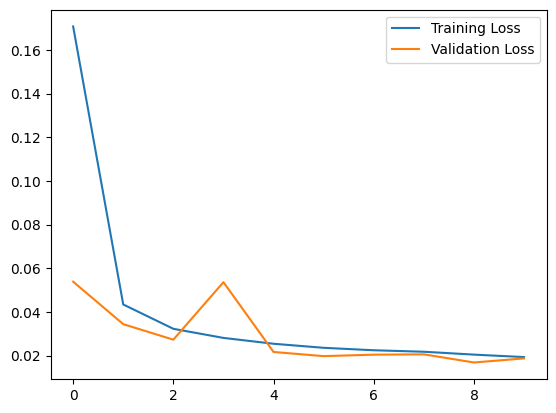

In [82]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

6184/6184 [==============================] - 8s 1ms/step


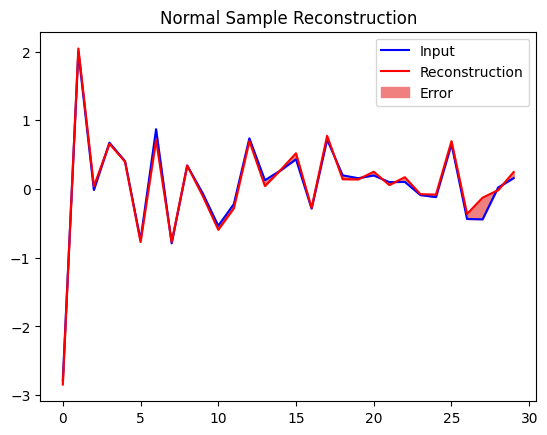

In [85]:
decoded_normal_data = vae.predict(normal_reducted_X_train)

plt.plot(normal_reducted_X_train[2], 'b')
plt.plot(decoded_normal_data[2], 'r')
plt.fill_between(np.arange(30), decoded_normal_data[2], normal_reducted_X_train[2], color='lightcoral')
plt.title("Normal Sample Reconstruction")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

544/544 [==============================] - 1s 2ms/step


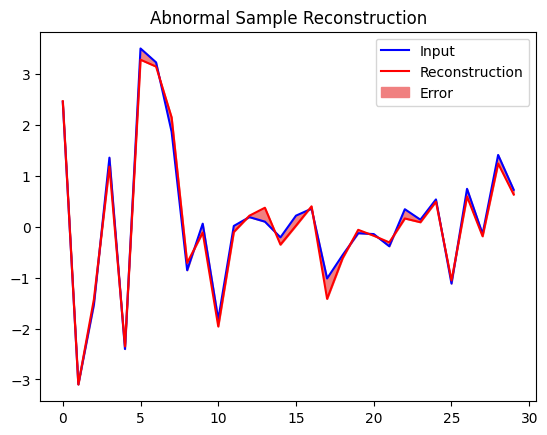

In [86]:
decoded_abnormal_data = vae.predict(abnormal_reducted_X_train)

plt.plot(abnormal_reducted_X_train[2], 'b')
plt.plot(decoded_abnormal_data[2], 'r')
plt.fill_between(np.arange(30), decoded_abnormal_data[2], abnormal_reducted_X_train[2], color='lightcoral')
plt.title("Abnormal Sample Reconstruction")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

6184/6184 [==============================] - 8s 1ms/step


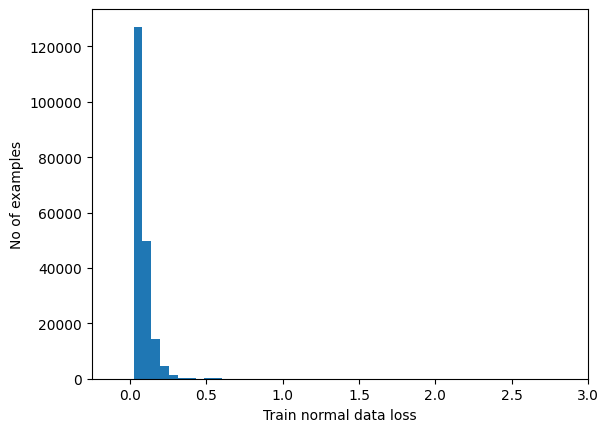

In [91]:
reconstructions = vae.predict(normal_reducted_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_reducted_X_train)

plt.hist(train_loss[None,:], bins=100)
plt.xlabel("Train normal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

544/544 [==============================] - 1s 1ms/step


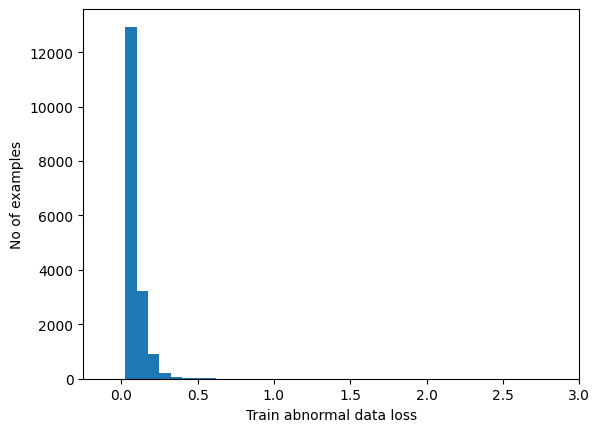

In [92]:
reconstructions = vae.predict(abnormal_reducted_X_train)
train_loss = tf.keras.losses.mae(reconstructions, abnormal_reducted_X_train)

plt.hist(train_loss[None,:], bins=500)
plt.xlabel("Train abnormal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

1767/1767 [==============================] - 3s 1ms/step


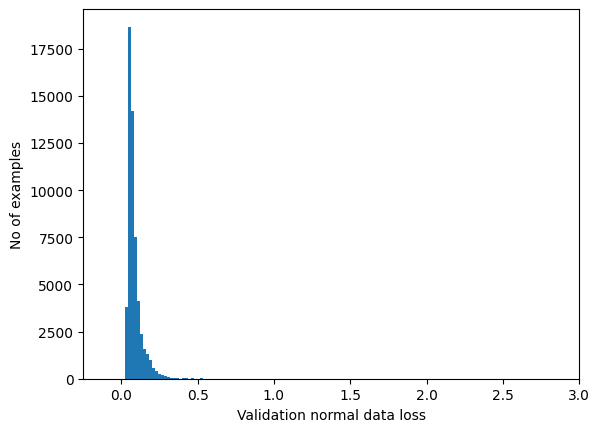

In [89]:
reconstructions = vae.predict(normal_reducted_X_validation)
train_loss = tf.keras.losses.mae(reconstructions, normal_reducted_X_validation)

plt.hist(train_loss[None,:], bins=150)
plt.xlabel("Validation normal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

156/156 [==============================] - 0s 2ms/step


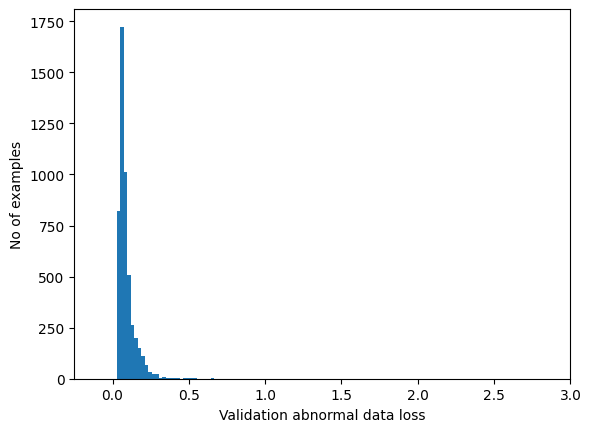

In [90]:
reconstructions = vae.predict(abnormal_reducted_X_validation)
train_loss = tf.keras.losses.mae(reconstructions, abnormal_reducted_X_validation)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Validation abnormal data loss")
plt.ylabel("No of examples")
plt.xlim([-0.25, 3])
plt.show()

## Reconstruction Error

In [95]:
validation_reconstructions = vae.predict(reducted_X_validation)
y_hat_validation = tf.keras.losses.mae(validation_reconstructions, reducted_X_validation)
y_hat_validation = y_hat_validation.numpy().reshape(-1,1)

1922/1922 [==============================] - 3s 2ms/step


In [96]:
y_hat_validation

array([[0.095495  ],
       [0.05359916],
       [0.06374892],
       ...,
       [0.11912866],
       [0.04370626],
       [0.08955926]])

In [97]:
roc_auc_score(y_validation, y_hat_validation)

0.5376651934003382

In [114]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 4, total= 1, start=0.1, end=.2, num=100)
threshold

0.13737373737373737

In [115]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]

print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     56537
           1       0.10      0.14      0.12      4965

    accuracy                           0.83     61502
   macro avg       0.51      0.52      0.51     61502
weighted avg       0.86      0.83      0.84     61502



In [116]:
test_reconstructions = vae.predict(reducted_X_test)
y_hat_test = tf.keras.losses.mae(test_reconstructions, reducted_X_test)
y_hat_test = y_hat_test.numpy().reshape(-1,1)

961/961 [==============================] - 2s 2ms/step


In [117]:
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     28269
           1       0.09      0.13      0.11      2483

    accuracy                           0.83     30752
   macro avg       0.51      0.51      0.51     30752
weighted avg       0.85      0.83      0.84     30752



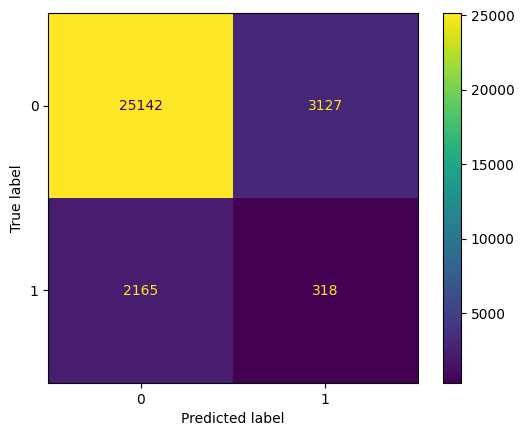

In [119]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Hidden State

In [131]:
mean_train, logvar_train = vae.encode(reducted_X_train)
train_hidden_state = vae.reparameterize(mean_train, logvar_train).numpy()

mean_validation, logvar_validation = vae.encode(reducted_X_validation)
validation_hidden_state = vae.reparameterize(mean_validation, logvar_validation).numpy()

mean_test, logvar_test = vae.encode(reducted_X_test)
test_hidden_state = vae.reparameterize(mean_test, logvar_test).numpy()


In [133]:
train_hidden_state.shape

(215257, 16)

In [134]:
mlp_for_hidden = Sequential()
mlp_for_hidden.add(Dense(64, activation='relu'))
mlp_for_hidden.add(Dense(64, activation='relu'))
mlp_for_hidden.add(Dense(1, activation='sigmoid'))

In [135]:
mlp_for_hidden.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [136]:
callback  = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5,
)

In [137]:
a , b = np.unique(y_train, return_counts= True)
count_lable = dict(zip(a,b))
ratio = {0: 1, 1: count_lable[0]/count_lable[1]}
ratio

{0: 1, 1: 11.38746619094205}

In [138]:
mlp_for_hidden.fit(train_hidden_state, y_train, validation_data=(validation_hidden_state, y_validation), 
    epochs=20, batch_size=128, class_weight= ratio, callbacks=[callback])

Epoch 1/20
1682/1682 [==============================] - 5s 2ms/step - loss: 1.1677 - accuracy: 0.6265 - val_loss: 0.6740 - val_accuracy: 0.6024
Epoch 2/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1467 - accuracy: 0.6492 - val_loss: 0.5957 - val_accuracy: 0.6762
Epoch 3/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1398 - accuracy: 0.6538 - val_loss: 0.6279 - val_accuracy: 0.6502
Epoch 4/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1355 - accuracy: 0.6587 - val_loss: 0.5869 - val_accuracy: 0.6894
Epoch 5/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1322 - accuracy: 0.6610 - val_loss: 0.5630 - val_accuracy: 0.7130
Epoch 6/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1305 - accuracy: 0.6618 - val_loss: 0.6185 - val_accuracy: 0.6616
Epoch 7/20
1682/1682 [==============================] - 4s 2ms/step - loss: 1.1277 - accuracy: 0.6633 - val_loss: 0.6283 - val_accuracy:

In [139]:
y_hat_validation = mlp_for_hidden.predict(validation_hidden_state)
y_hat_validation

1922/1922 [==============================] - 3s 1ms/step


array([[0.62125355],
       [0.33292186],
       [0.2809652 ],
       ...,
       [0.747943  ],
       [0.29591906],
       [0.36915147]], dtype=float32)

In [140]:
roc_auc_score(y_validation, y_hat_validation)

0.7214512304777873

In [141]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 4, total= 1, start=0.5, end=0.9, num=100)
threshold

0.7181818181818181

In [142]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]

print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56537
           1       0.23      0.33      0.27      4965

    accuracy                           0.86     61502
   macro avg       0.58      0.62      0.60     61502
weighted avg       0.88      0.86      0.87     61502



In [143]:
y_hat_test = mlp_for_hidden.predict(test_hidden_state)
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

961/961 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     28269
           1       0.22      0.31      0.26      2483

    accuracy                           0.86     30752
   macro avg       0.58      0.61      0.59     30752
weighted avg       0.88      0.86      0.87     30752



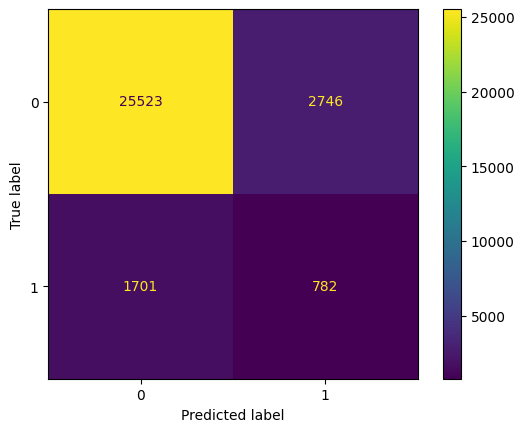

In [144]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [145]:
class hidden_mlp(tf.keras.Model):

  def __init__(self, latent_dim):
    super(hidden_mlp, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid')
            
        ]
    )

  @tf.function
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    return logits

  def call(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    predictions = self.decode(z)
    return(predictions)

In [146]:
hm = hidden_mlp(32)

In [147]:
hm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [148]:
hm.fit(reducted_X_train, y_train, validation_data=(reducted_X_validation, y_validation), 
    epochs=20, batch_size=64, class_weight= ratio, callbacks=[callback])

Epoch 1/20
3364/3364 [==============================] - 12s 3ms/step - loss: 1.1750 - accuracy: 0.6497 - val_loss: 0.6728 - val_accuracy: 0.5785
Epoch 2/20
3364/3364 [==============================] - 10s 3ms/step - loss: 1.1322 - accuracy: 0.6539 - val_loss: 0.5851 - val_accuracy: 0.6745
Epoch 3/20
3364/3364 [==============================] - 10s 3ms/step - loss: 1.1282 - accuracy: 0.6487 - val_loss: 0.6249 - val_accuracy: 0.6367
Epoch 4/20
3364/3364 [==============================] - 10s 3ms/step - loss: 1.4929 - accuracy: 0.6505 - val_loss: 0.6515 - val_accuracy: 0.6183
Epoch 5/20
3364/3364 [==============================] - 10s 3ms/step - loss: 1.1198 - accuracy: 0.6536 - val_loss: 0.6242 - val_accuracy: 0.6365
Epoch 6/20
3364/3364 [==============================] - 10s 3ms/step - loss: 1.1180 - accuracy: 0.6535 - val_loss: 0.5951 - val_accuracy: 0.6718
Epoch 7/20
3364/3364 [==============================] - 11s 3ms/step - loss: 1.1153 - accuracy: 0.6528 - val_loss: 0.5864 - val_ac

In [149]:
y_hat_validation = hm.predict(reducted_X_validation)
y_hat_validation

1922/1922 [==============================] - 3s 2ms/step


array([[0.58928615],
       [0.4145366 ],
       [0.300709  ],
       ...,
       [0.6471806 ],
       [0.29810908],
       [0.28813177]], dtype=float32)

In [150]:
roc_auc_score(y_validation,y_hat_validation)

0.7263165735862518

In [151]:
threshold = set_threshold (y_validation, y_hat_validation, cat_0 = 1, cat_1 = 5, total= 1, start=0.5, end=0.9, num=100)
threshold

0.6494949494949495

In [152]:
y_predict_validation = [0 if val < threshold else 1 for val in y_hat_validation]
from sklearn.metrics import classification_report
print(classification_report(y_validation, y_predict_validation))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56537
           1       0.22      0.37      0.28      4965

    accuracy                           0.84     61502
   macro avg       0.58      0.63      0.59     61502
weighted avg       0.88      0.84      0.86     61502



In [154]:
y_hat_test = hm.predict(reducted_X_test)
y_predict_test = [0 if val < threshold else 1 for val in y_hat_test]

print(classification_report(y_test, y_predict_test))

961/961 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     28269
           1       0.22      0.38      0.28      2483

    accuracy                           0.84     30752
   macro avg       0.58      0.63      0.59     30752
weighted avg       0.88      0.84      0.86     30752



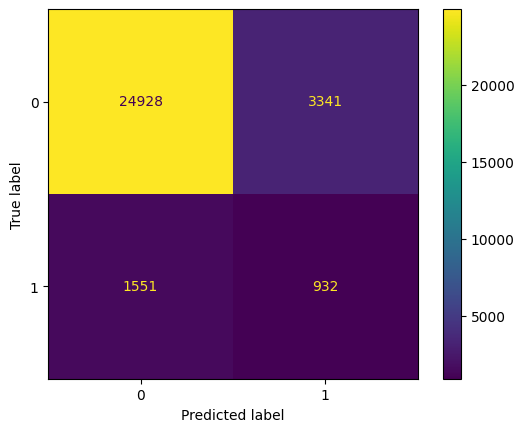

In [155]:
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()